In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.10.0


In [3]:
# Si ves una lista con al menos un dispositivo GPU, TensorFlow la está detectando.
# Si la lista está vacía ([]), TensorFlow no está usando la GPU.
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importación de librerias.

In [4]:
(imagenes_entrenamiento, etiquetas_entrenamiento ), (imagenes_verificacion, etiquetas_verificacion) = keras.datasets.cifar10.load_data()

Carga de conjunto de datos de imagenes para entrenamiento. 50.000 fotos en color de 32x32 pixels de aviones, trenes, autos, etc con etiquetas. 10000 fotos para testear

In [5]:
print(etiquetas_entrenamiento.shape, imagenes_entrenamiento.shape)

(50000, 1) (50000, 32, 32, 3)


In [6]:
imagenes_entrenamiento, imagenes_verificacion = imagenes_entrenamiento / 255.0, imagenes_verificacion  / 255.0

AGREGADO: Estandarizacion entre 0s y 1s

In [7]:
nombres_clases = ['airplane','automobile','bird','cat','deer',
                  'dog','frog','horse','ship','truck']

Funcion para mostrar imagenes en miniatura.

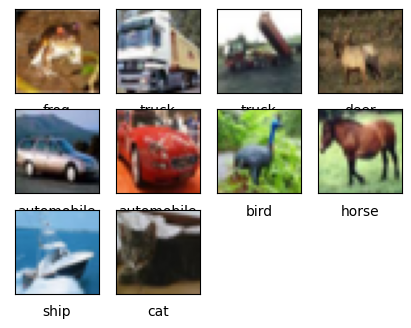

In [8]:
import matplotlib.pyplot as plt
def mostrar():
  plt.figure(figsize=(5,5))
  for i in range(10):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagenes_entrenamiento[i], cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiquetas_entrenamiento[i][0]])
  plt.show()
mostrar()

Una capa de entrada para imagenes de 32x32 pixels con 3 dimensiones de colores.
Dos capas convolucionales para extraer caracteristicas, con 32 filtros de 3x3. Quitando relleno que no se ajusta.
Dos capas de agrupamiento con filtros de 2x2 para achicar la anterior.

Una capa complemtamente conectada (densa) con 64 neuronas.
Una capa de salida con 10 neuronas para clasificar.

In [9]:
capa = keras.layers
modelo = keras.models.Sequential()
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(32,32,3)))
modelo.add(capa.BatchNormalization())
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu')) # capa extra
modelo.add(capa.BatchNormalization()) 
modelo.add(capa.MaxPool2D(2,2))
modelo.add(capa.Dropout(0.3)) # ajusto de 0.25 a 0.3

modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu')) # aumento el número de filtros de 64 a 128
modelo.add(capa.BatchNormalization())
modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu')) # capa extra
modelo.add(capa.BatchNormalization())
modelo.add(capa.MaxPool2D(2,2))
modelo.add(capa.Dropout(0.3)) # ajusto de 0.25 a 0.3

modelo.add(capa.Flatten())
modelo.add(capa.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) # aumento el número de neuronas de 64 a 128
modelo.add(capa.Dropout(0.5))
modelo.add(capa.Dense(10, activation='softmax')) # agrego softmax para clasificacion multiclase 

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

Configuracion del modelo

In [10]:
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamiento (creación del modelo)

Loss se busca el número mas bajo. Accuracy el más alto

In [11]:
# Callbacks para optimizar el entrenamiento
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# 1. Crear una pipeline de datos eficiente con tf.data
# Capas para hacer Data Augmentation en la GPU (mucho más rápido)
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Crear los datasets
batch_size = 256 # Un batch size más grande es mejor para la GPU
autotune = tf.data.AUTOTUNE # Permite a TensorFlow optimizar la pipeline automáticamente

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((imagenes_entrenamiento, etiquetas_entrenamiento))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(buffer_size=autotune) # ¡Esta es la clave!

# Dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((imagenes_verificacion, etiquetas_verificacion))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=autotune)


# 2. Definición de Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('mejor_modelo.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# 3. Entrenamiento del modelo usando la nueva pipeline de datos
history = modelo.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/100
196/196 [==============================] - 21s 61ms/step - loss: 2.3689 - accuracy: 0.2423 - val_loss: 3.7654 - val_accuracy: 0.1131 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 12s 58ms/step - loss: 1.9498 - accuracy: 0.3398 - val_loss: 2.6401 - val_accuracy: 0.2326 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 12s 57ms/step - loss: 1.7746 - accuracy: 0.3932 - val_loss: 1.6512 - val_accuracy: 0.4559 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 12s 57ms/step - loss: 1.6210 - accuracy: 0.4516 - val_loss: 1.6454 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 12s 57ms/step - loss: 1.5397 - accuracy: 0.4857 - val_loss: 1.9315 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/100
196/196 [==============================] - 12s 58ms/step - loss: 1.4672 - accuracy: 0.5168 - val_loss: 1.3314 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 7/100
196/196 [==============================]

In [12]:
modelo.evaluate(imagenes_verificacion, etiquetas_verificacion, batch_size=256)

40/40 [==============================] - 0s 5ms/step - loss: 0.5759 - accuracy: 0.8407


[0.5759487152099609, 0.8406999707221985]

In [ ]:
#predict()

**CONTINUAR DESDE ACA**

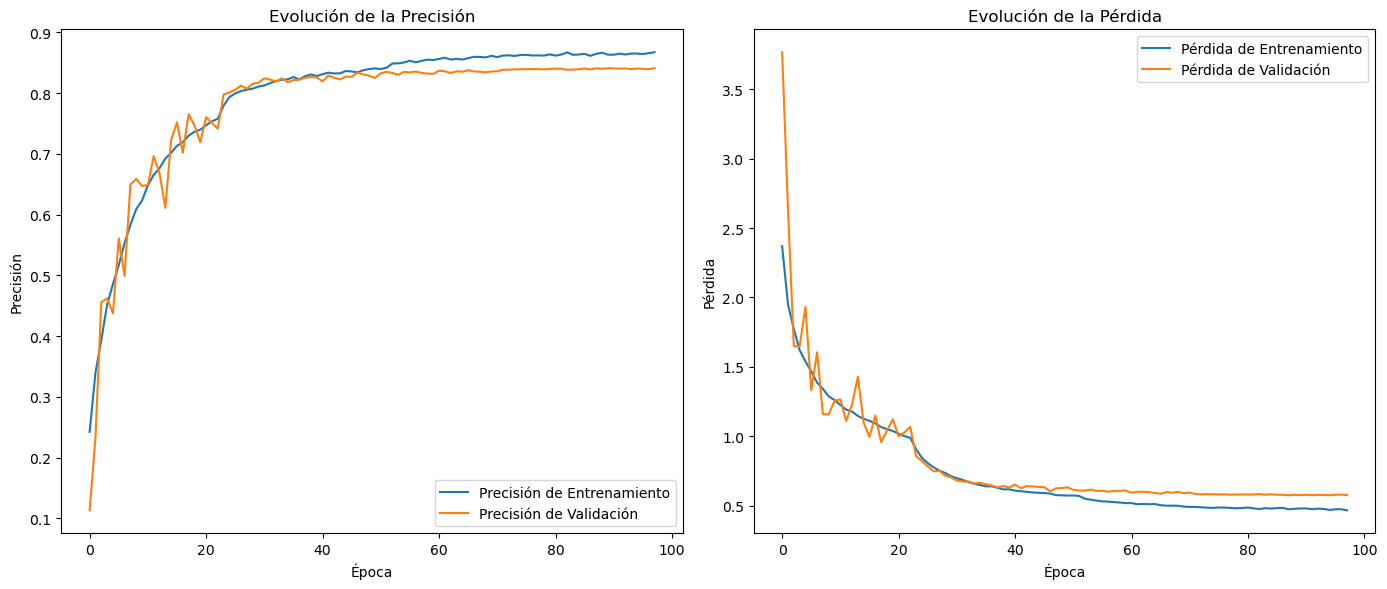

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el historial a un DataFrame para facilitar el ploteo
history_df = pd.DataFrame(history.history)

# Graficar la precisión
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history_df['val_accuracy'], label='Precisión de Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_df['val_loss'], label='Pérdida de Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


Precisión del mejor modelo cargado: 84.07%
313/313 [==============================] - 1s 2ms/step


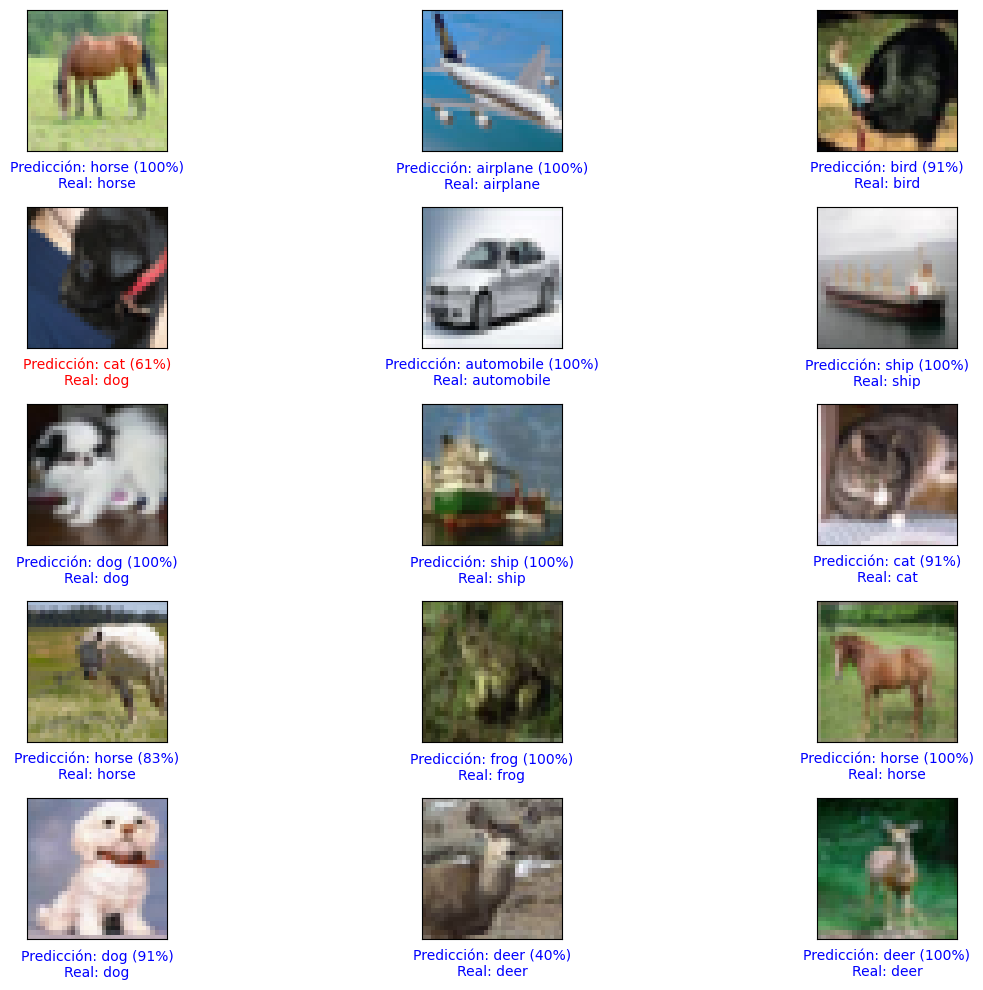

In [14]:
import numpy as np

# Cargar el mejor modelo guardado por ModelCheckpoint
best_model = keras.models.load_model('mejor_modelo.keras')

# Evaluar el mejor modelo para confirmar su rendimiento
loss, acc = best_model.evaluate(imagenes_verificacion, etiquetas_verificacion, verbose=0)
print(f'\nPrecisión del mejor modelo cargado: {acc*100:.2f}%')


# --- Hacer predicciones y visualizarlas ---
predictions = best_model.predict(imagenes_verificacion)

# Función para mostrar una imagen con su predicción
def plot_image_prediction(i, predictions_array, true_labels, img_array):
  true_label, img = true_labels[i][0], img_array[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  
  # Poner el título en azul si es correcto, en rojo si es incorrecto
  color = 'blue' if predicted_label == true_label else 'red'
  
  plt.xlabel(f"Predicción: {nombres_clases[predicted_label]} ({100*np.max(predictions_array):2.0f}%)\nReal: {nombres_clases[true_label]}", color=color)

# Mostrar 15 imágenes aleatorias con sus predicciones
num_rows = 5
num_cols = 3
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_rows * num_cols):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  random_index = np.random.randint(0, len(imagenes_verificacion))
  plot_image_prediction(random_index, predictions[random_index], etiquetas_verificacion, imagenes_verificacion)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- DEFINICIÓN DE LA FUNCIÓN ---
# Esta es la celda que faltaba.
def predecir_imagen_externa(ruta_imagen, modelo):
    try:
        # 1. Cargar la imagen y redimensionarla a 32x32 píxeles
        img = image.load_img(ruta_imagen, target_size=(32, 32))
        
        # 2. Convertir la imagen a un array de numpy y normalizarla
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        
        # 3. Añadir una dimensión extra para que represente un "lote" de 1 imagen
        img_batch = np.expand_dims(img_array, axis=0)
        
        # 4. Realizar la predicción
        prediccion = modelo.predict(img_batch)
        
        # 5. Obtener la clase con la probabilidad más alta
        clase_predicha = np.argmax(prediccion[0])
        confianza = np.max(prediccion[0]) * 100
        
        # 6. Mostrar la imagen y el resultado
        plt.imshow(img)
        plt.title(f"Predicción: {nombres_clases[clase_predicha]} ({confianza:.2f}%)")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta '{ruta_imagen}'.")
    except Exception as e:
        print(f"Ocurrió un error al procesar la imagen: {e}")

Iniciando predicciones para las 137 imágenes procesadas...

--- Prediciendo: descarga (1).jpg ---
1/1 [==============================] - 0s 52ms/step


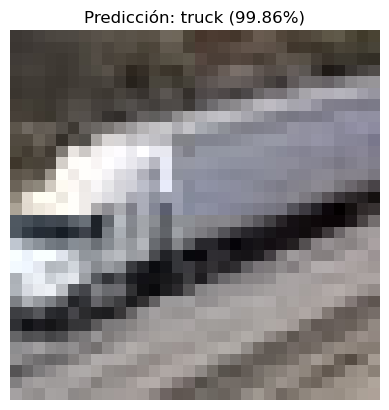


--- Prediciendo: descarga (10).jpg ---
1/1 [==============================] - 0s 15ms/step


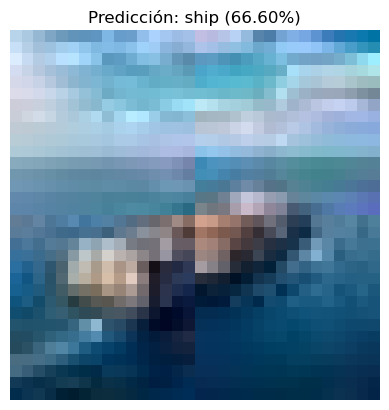


--- Prediciendo: descarga (11).jpg ---
1/1 [==============================] - 0s 13ms/step


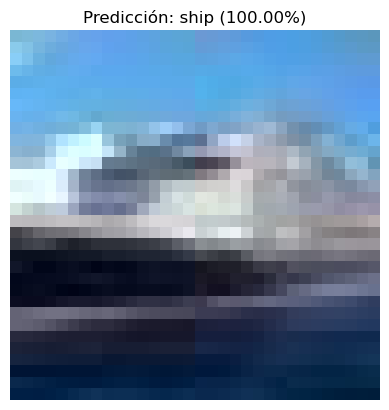


--- Prediciendo: descarga (12).jpg ---
1/1 [==============================] - 0s 14ms/step


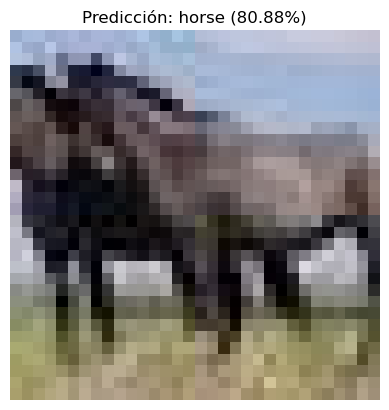


--- Prediciendo: descarga (13).jpg ---
1/1 [==============================] - 0s 14ms/step


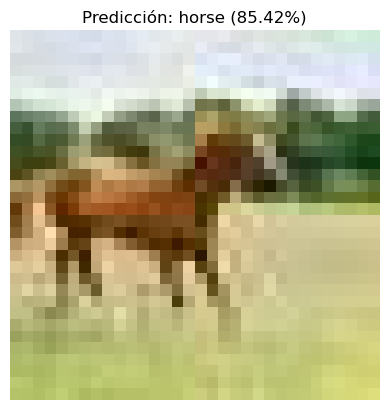


--- Prediciendo: descarga (14).jpg ---
1/1 [==============================] - 0s 14ms/step


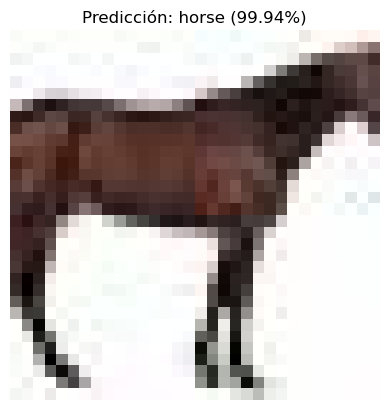


--- Prediciendo: descarga (15).jpg ---
1/1 [==============================] - 0s 16ms/step


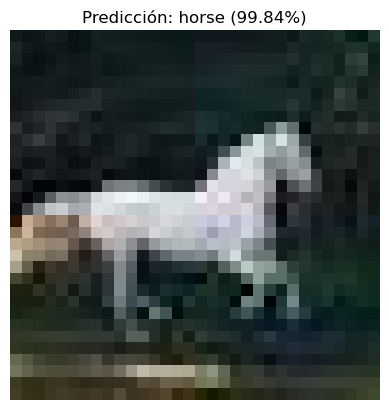


--- Prediciendo: descarga (16).jpg ---
1/1 [==============================] - 0s 14ms/step


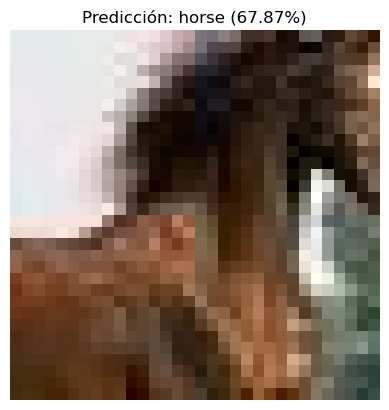


--- Prediciendo: descarga (17).jpg ---
1/1 [==============================] - 0s 13ms/step


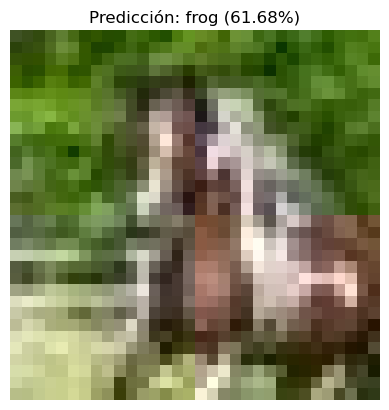


--- Prediciendo: descarga (18).jpg ---
1/1 [==============================] - 0s 15ms/step


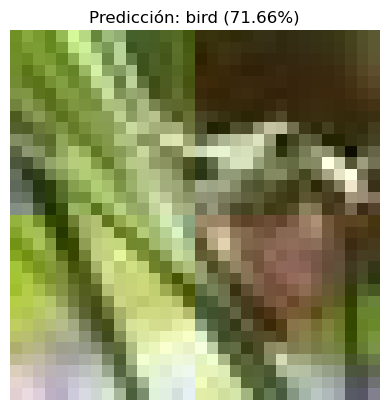


--- Prediciendo: descarga (19).jpg ---
1/1 [==============================] - 0s 14ms/step


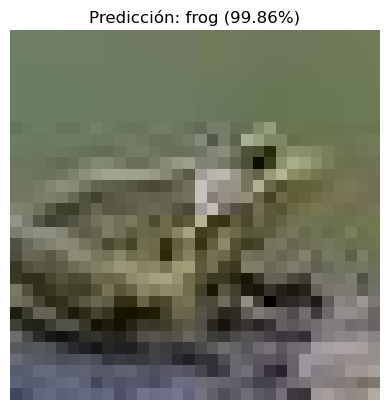


--- Prediciendo: descarga (2).jpg ---
1/1 [==============================] - 0s 15ms/step


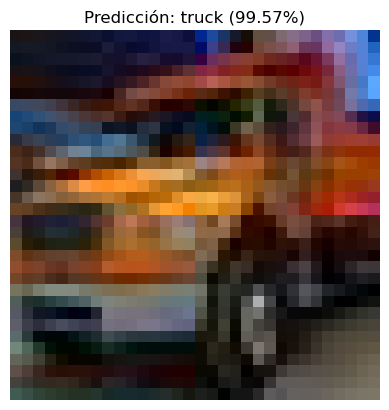


--- Prediciendo: descarga (20).jpg ---
1/1 [==============================] - 0s 15ms/step


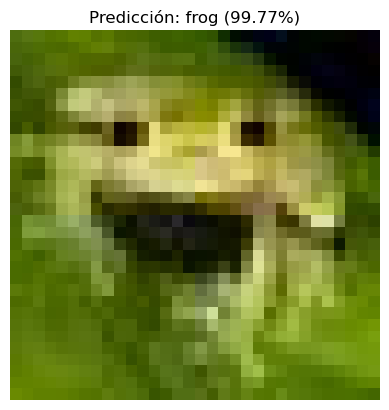


--- Prediciendo: descarga (21).jpg ---
1/1 [==============================] - 0s 14ms/step


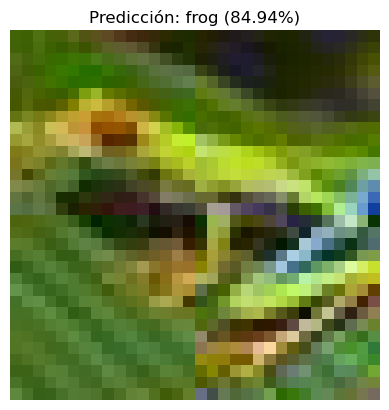


--- Prediciendo: descarga (22).jpg ---
1/1 [==============================] - 0s 13ms/step


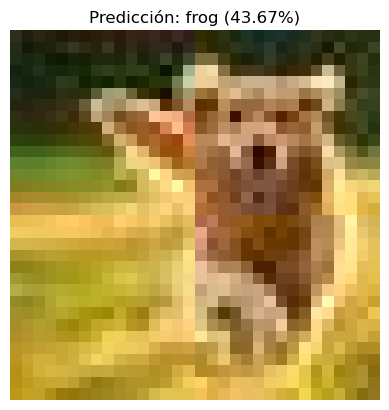


--- Prediciendo: descarga (23).jpg ---
1/1 [==============================] - 0s 13ms/step


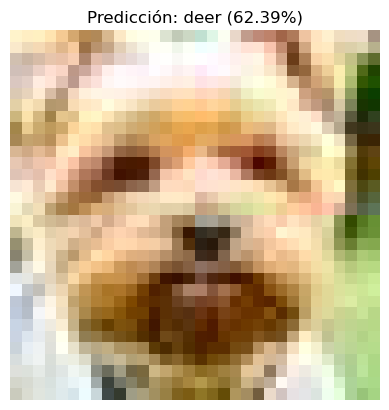


--- Prediciendo: descarga (24).jpg ---
1/1 [==============================] - 0s 13ms/step


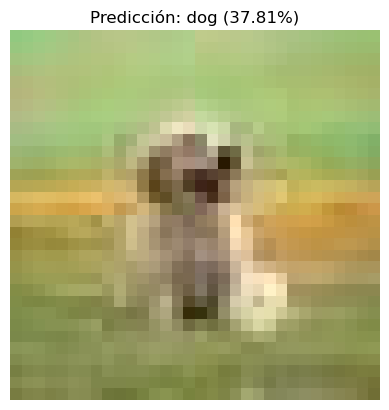


--- Prediciendo: descarga (25).jpg ---
1/1 [==============================] - 0s 14ms/step


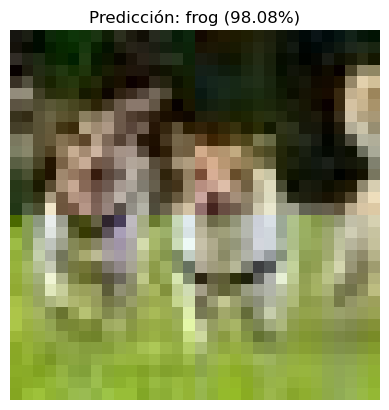


--- Prediciendo: descarga (26).jpg ---
1/1 [==============================] - 0s 14ms/step


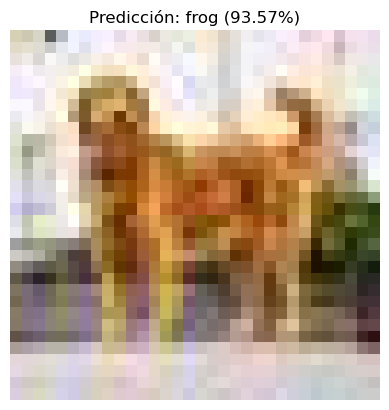


--- Prediciendo: descarga (27).jpg ---
1/1 [==============================] - 0s 18ms/step


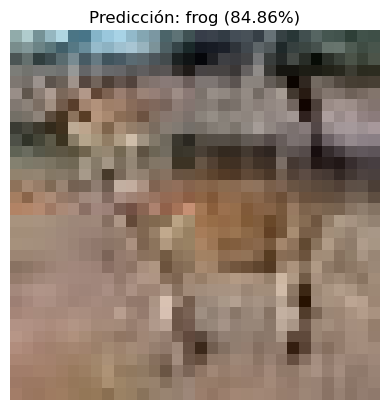


--- Prediciendo: descarga (28).jpg ---
1/1 [==============================] - 0s 14ms/step


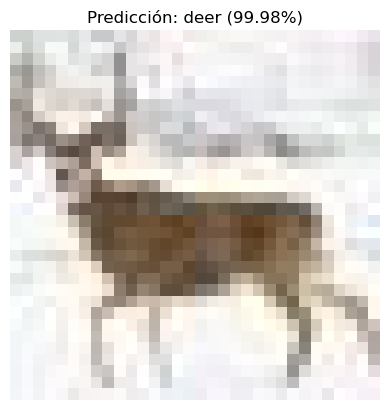


--- Prediciendo: descarga (29).jpg ---
1/1 [==============================] - 0s 15ms/step


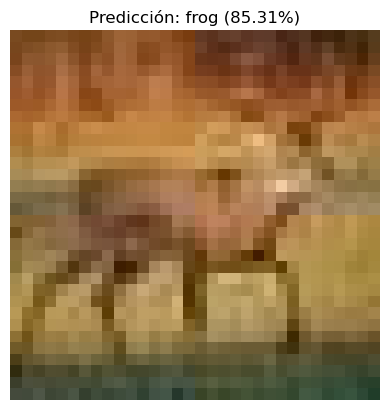


--- Prediciendo: descarga (3).jpg ---
1/1 [==============================] - 0s 14ms/step


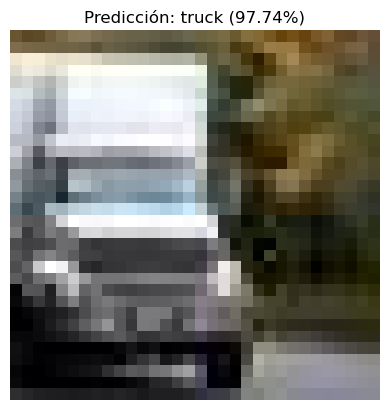


--- Prediciendo: descarga (30).jpg ---
1/1 [==============================] - 0s 15ms/step


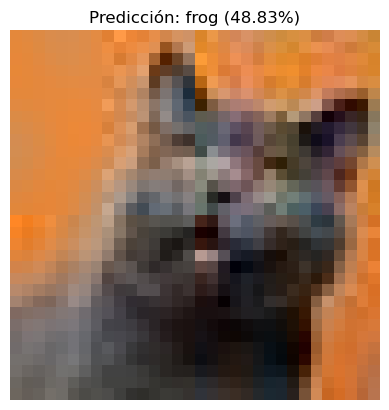


--- Prediciendo: descarga (31).jpg ---
1/1 [==============================] - 0s 13ms/step


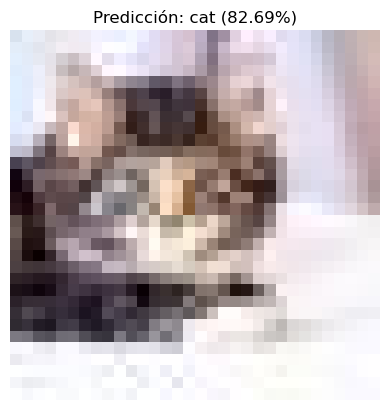


--- Prediciendo: descarga (32).jpg ---
1/1 [==============================] - 0s 17ms/step


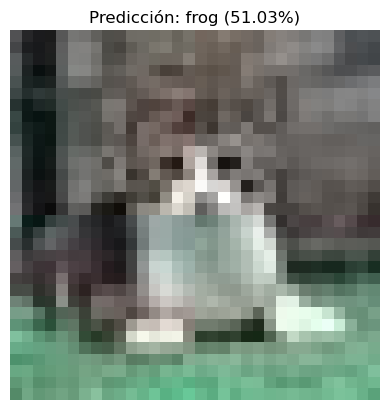


--- Prediciendo: descarga (33).jpg ---
1/1 [==============================] - 0s 15ms/step


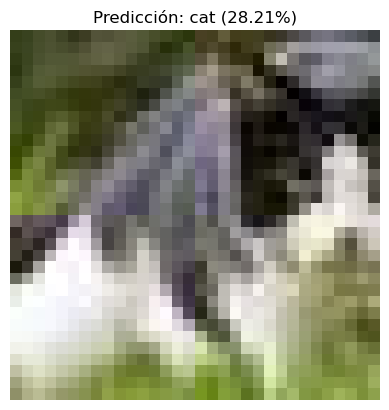


--- Prediciendo: descarga (34).jpg ---
1/1 [==============================] - 0s 14ms/step


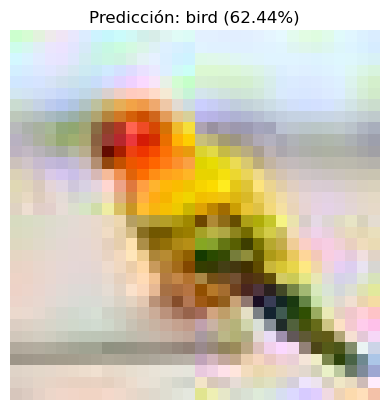


--- Prediciendo: descarga (35).jpg ---
1/1 [==============================] - 0s 13ms/step


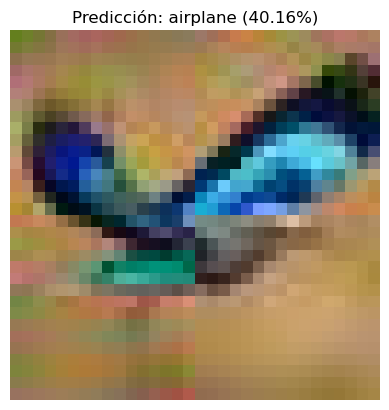


--- Prediciendo: descarga (36).jpg ---
1/1 [==============================] - 0s 14ms/step


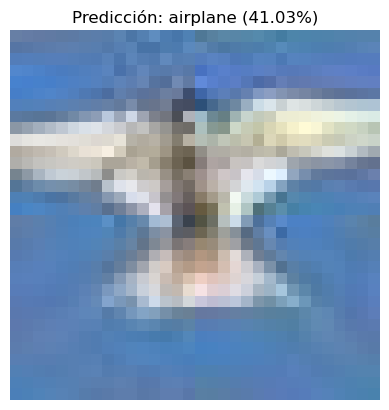


--- Prediciendo: descarga (37).jpg ---
1/1 [==============================] - 0s 13ms/step


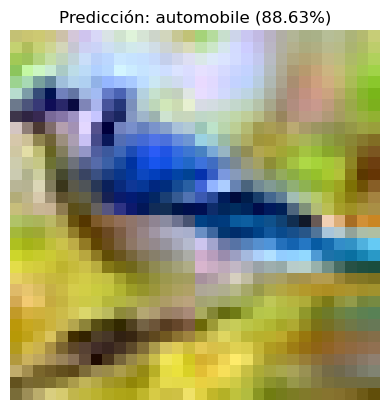


--- Prediciendo: descarga (38).jpg ---
1/1 [==============================] - 0s 14ms/step


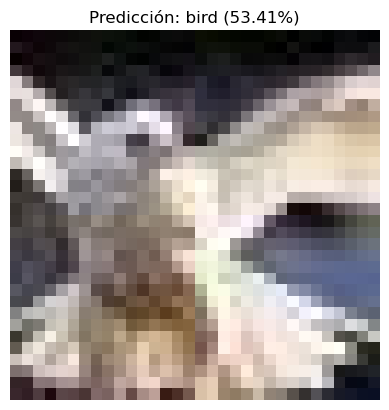


--- Prediciendo: descarga (39).jpg ---
1/1 [==============================] - 0s 14ms/step


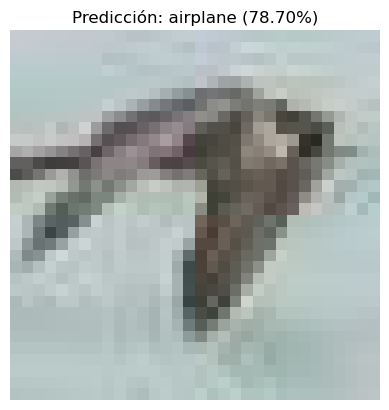


--- Prediciendo: descarga (4).jpg ---
1/1 [==============================] - 0s 14ms/step


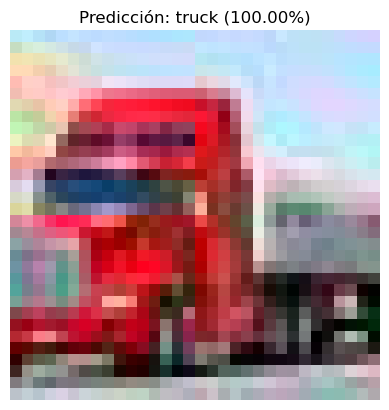


--- Prediciendo: descarga (40).jpg ---
1/1 [==============================] - 0s 14ms/step


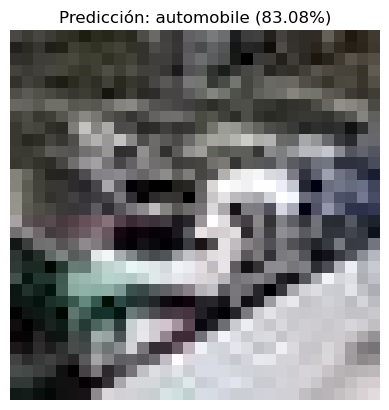


--- Prediciendo: descarga (41).jpg ---
1/1 [==============================] - 0s 14ms/step


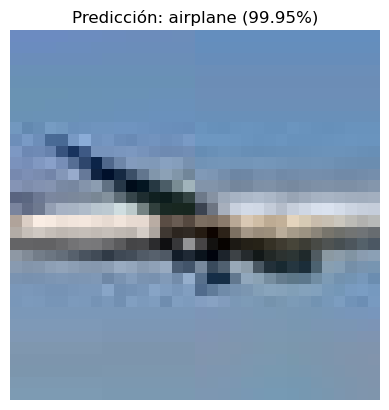


--- Prediciendo: descarga (42).jpg ---
1/1 [==============================] - 0s 14ms/step


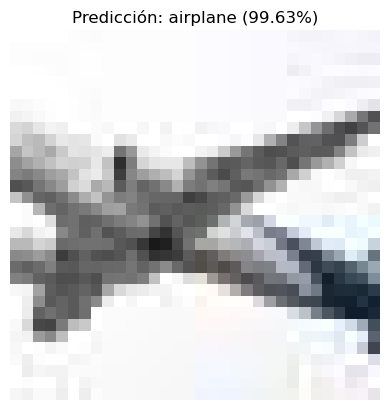


--- Prediciendo: descarga (43).jpg ---
1/1 [==============================] - 0s 13ms/step


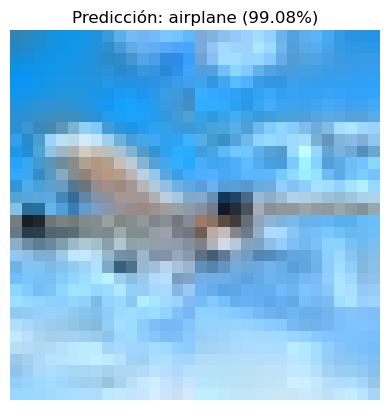


--- Prediciendo: descarga (44).jpg ---
1/1 [==============================] - 0s 13ms/step


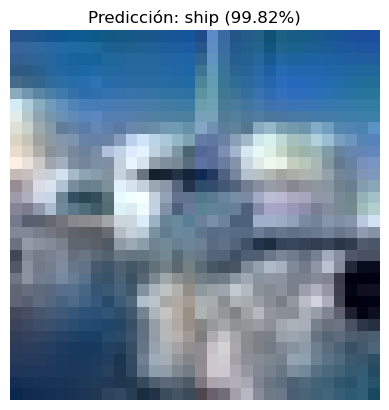


--- Prediciendo: descarga (45).jpg ---
1/1 [==============================] - 0s 15ms/step


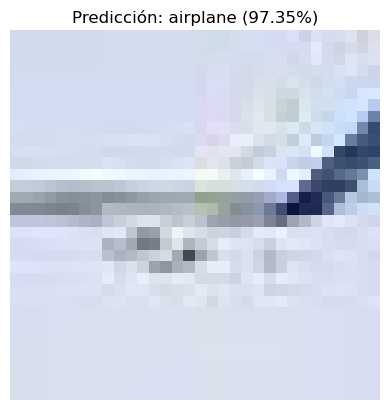


--- Prediciendo: descarga (5).jpg ---
1/1 [==============================] - 0s 14ms/step


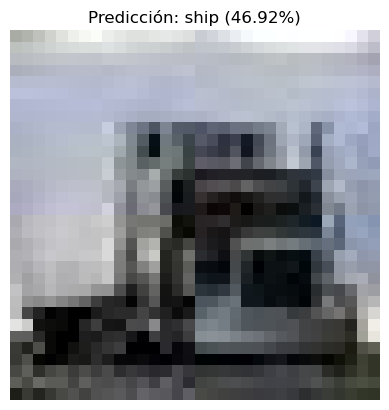


--- Prediciendo: descarga (6).jpg ---
1/1 [==============================] - 0s 15ms/step


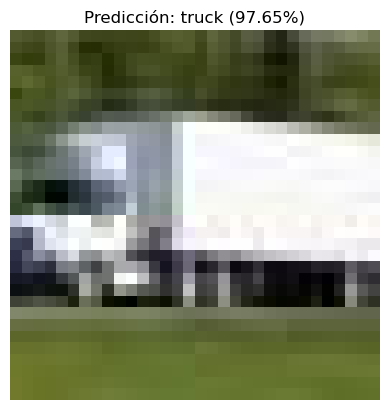


--- Prediciendo: descarga (7).jpg ---
1/1 [==============================] - 0s 14ms/step


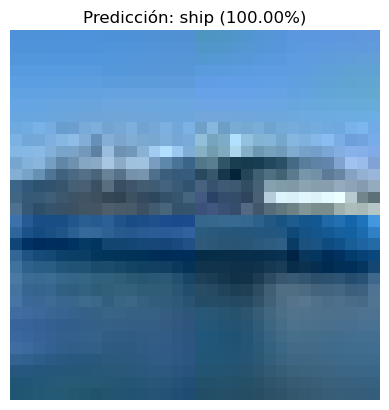


--- Prediciendo: descarga (8).jpg ---
1/1 [==============================] - 0s 14ms/step


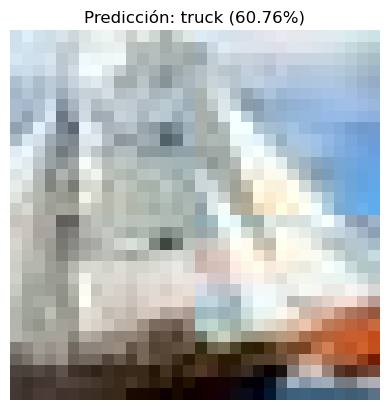


--- Prediciendo: descarga (9).jpg ---
1/1 [==============================] - 0s 14ms/step


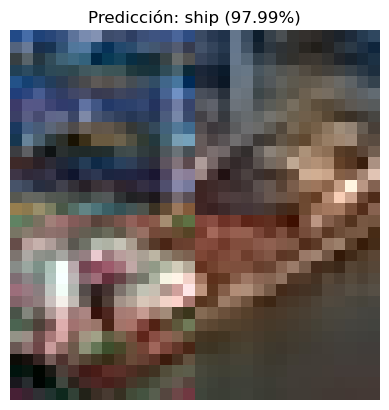


--- Prediciendo: descarga.jpg ---
1/1 [==============================] - 0s 14ms/step


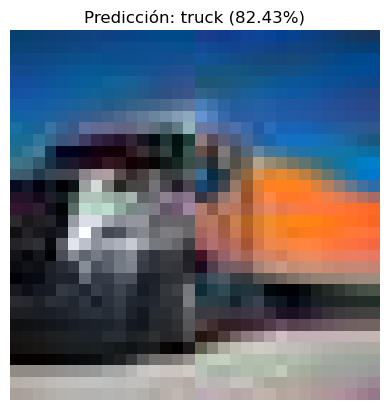


--- Prediciendo: images (1).jpg ---
1/1 [==============================] - 0s 15ms/step


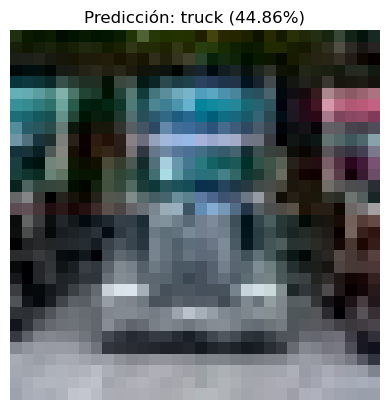


--- Prediciendo: images (10).jpg ---
1/1 [==============================] - 0s 13ms/step


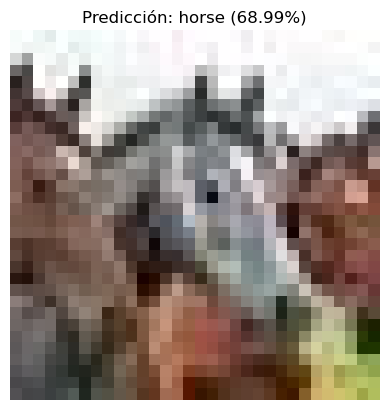


--- Prediciendo: images (11).jpg ---
1/1 [==============================] - 0s 17ms/step


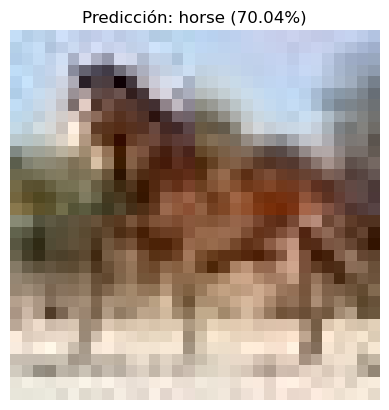


--- Prediciendo: images (12).jpg ---
1/1 [==============================] - 0s 15ms/step


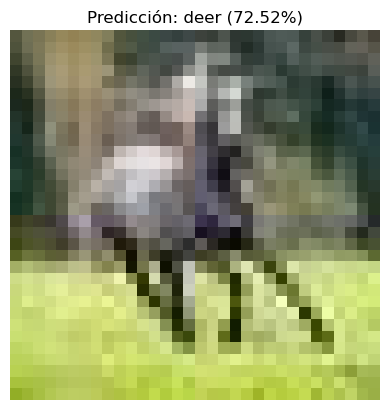


--- Prediciendo: images (13).jpg ---
1/1 [==============================] - 0s 14ms/step


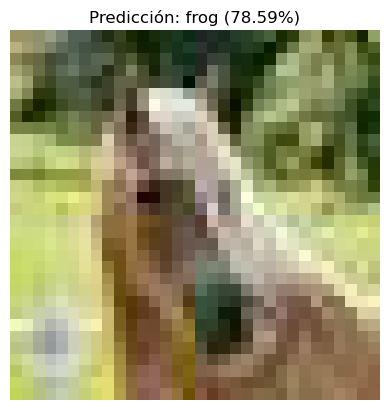


--- Prediciendo: images (14).jpg ---
1/1 [==============================] - 0s 14ms/step


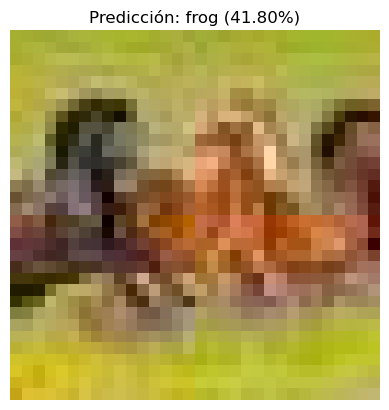


--- Prediciendo: images (15).jpg ---
1/1 [==============================] - 0s 21ms/step


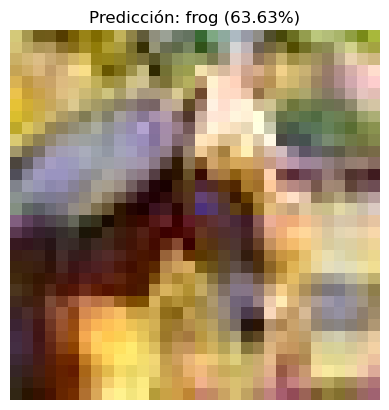


--- Prediciendo: images (16).jpg ---
1/1 [==============================] - 0s 15ms/step


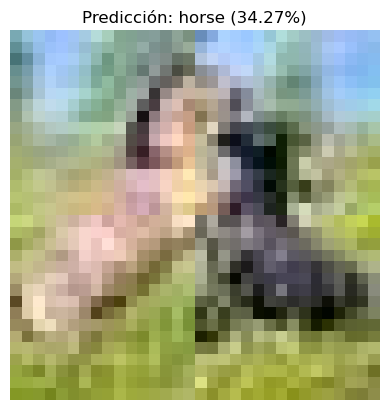


--- Prediciendo: images (17).jpg ---
1/1 [==============================] - 0s 14ms/step


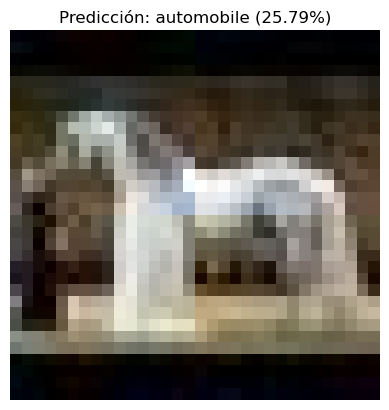


--- Prediciendo: images (18).jpg ---
1/1 [==============================] - 0s 15ms/step


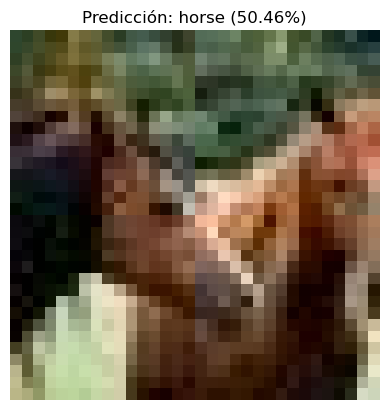


--- Prediciendo: images (19).jpg ---
1/1 [==============================] - 0s 14ms/step


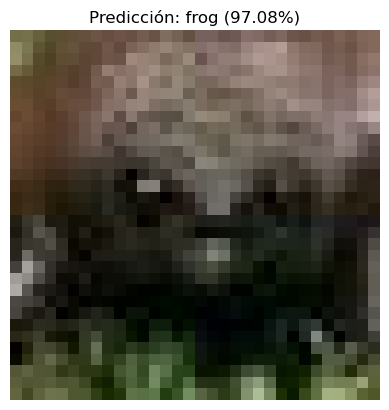


--- Prediciendo: images (2).jpg ---
1/1 [==============================] - 0s 14ms/step


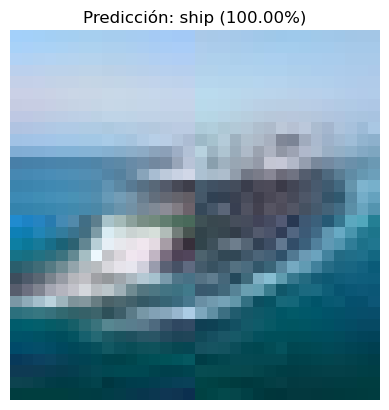


--- Prediciendo: images (20).jpg ---
1/1 [==============================] - 0s 14ms/step


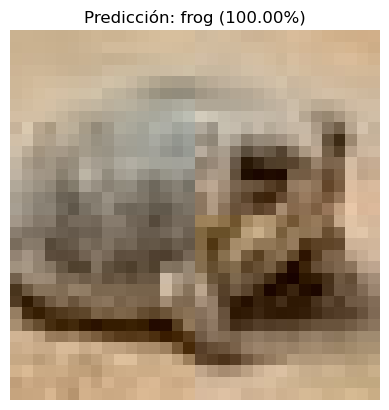


--- Prediciendo: images (21).jpg ---
1/1 [==============================] - 0s 14ms/step


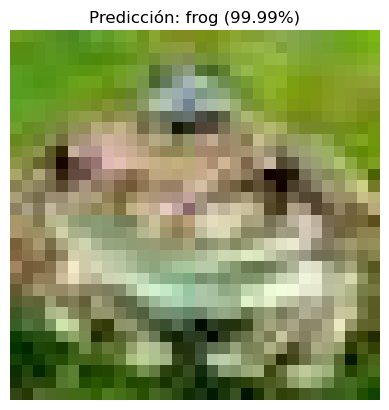


--- Prediciendo: images (22).jpg ---
1/1 [==============================] - 0s 14ms/step


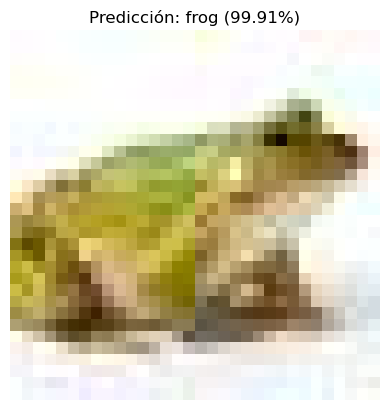


--- Prediciendo: images (23).jpg ---
1/1 [==============================] - 0s 14ms/step


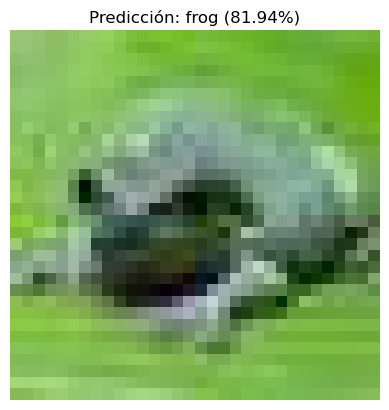


--- Prediciendo: images (24).jpg ---
1/1 [==============================] - 0s 13ms/step


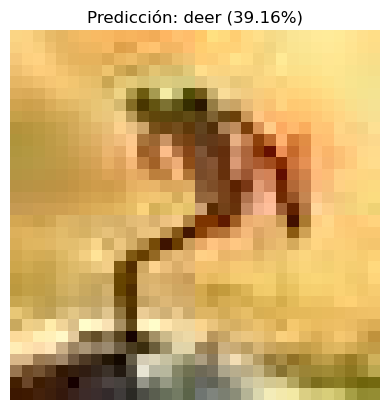


--- Prediciendo: images (25).jpg ---
1/1 [==============================] - 0s 14ms/step


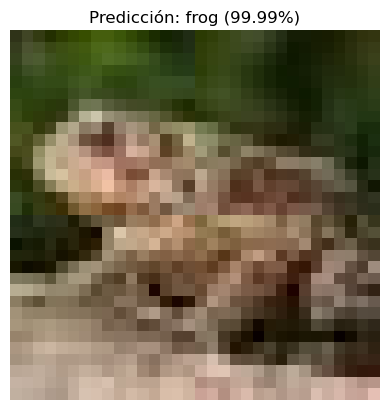


--- Prediciendo: images (26).jpg ---
1/1 [==============================] - 0s 14ms/step


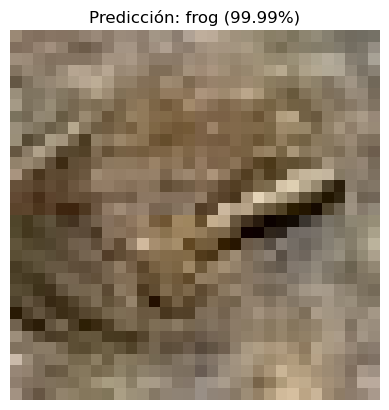


--- Prediciendo: images (27).jpg ---
1/1 [==============================] - 0s 14ms/step


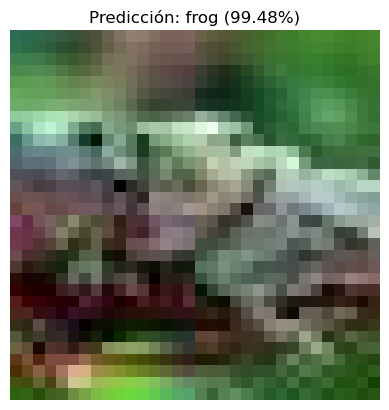


--- Prediciendo: images (28).jpg ---
1/1 [==============================] - 0s 13ms/step


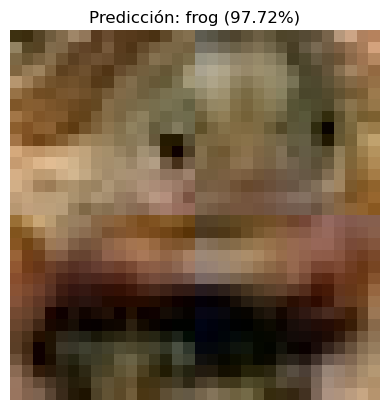


--- Prediciendo: images (29).jpg ---
1/1 [==============================] - 0s 13ms/step


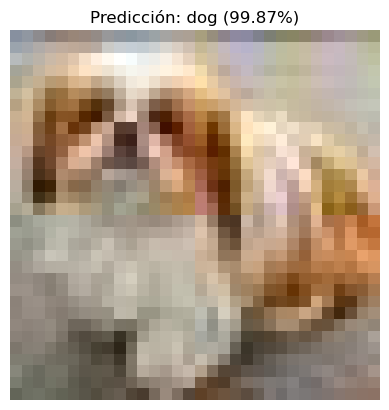


--- Prediciendo: images (3).jpg ---
1/1 [==============================] - 0s 15ms/step


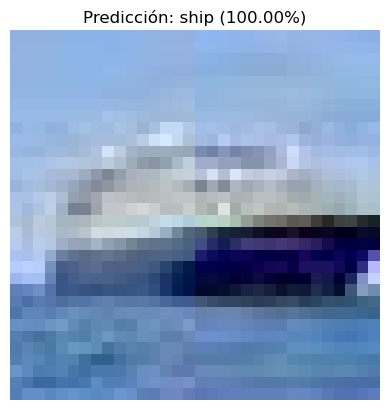


--- Prediciendo: images (30).jpg ---
1/1 [==============================] - 0s 15ms/step


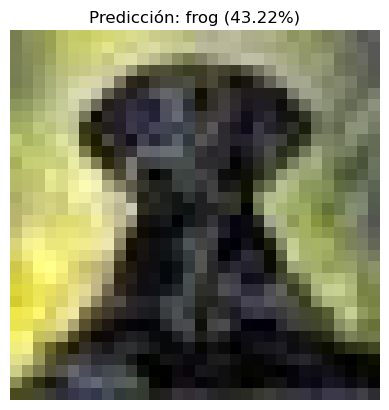


--- Prediciendo: images (31).jpg ---
1/1 [==============================] - 0s 15ms/step


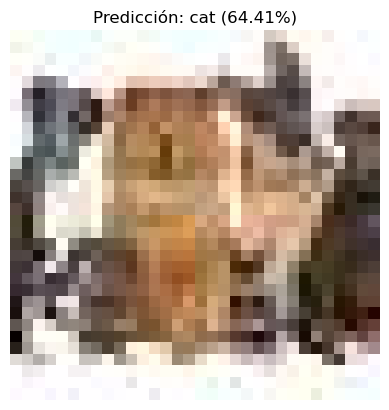


--- Prediciendo: images (32).jpg ---
1/1 [==============================] - 0s 14ms/step


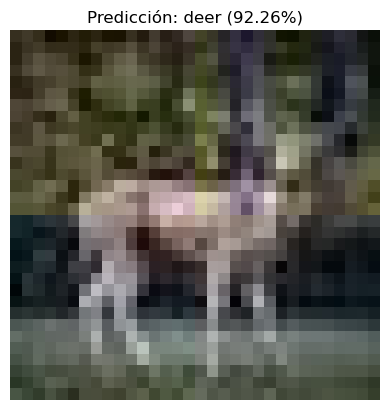


--- Prediciendo: images (33).jpg ---
1/1 [==============================] - 0s 14ms/step


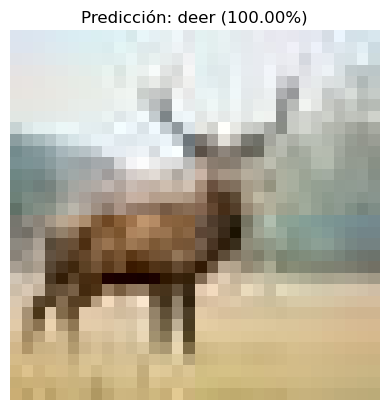


--- Prediciendo: images (34).jpg ---
1/1 [==============================] - 0s 15ms/step


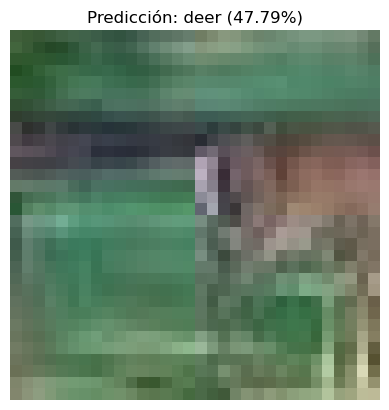


--- Prediciendo: images (35).jpg ---
1/1 [==============================] - 0s 14ms/step


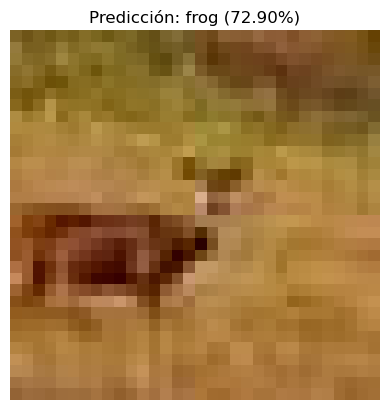


--- Prediciendo: images (36).jpg ---
1/1 [==============================] - 0s 14ms/step


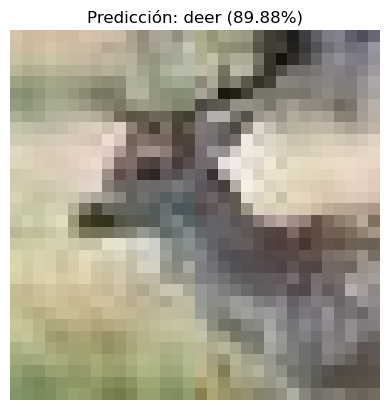


--- Prediciendo: images (37).jpg ---
1/1 [==============================] - 0s 19ms/step


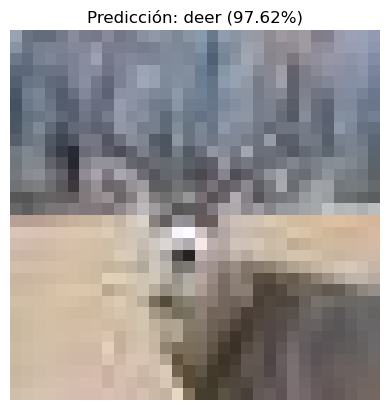


--- Prediciendo: images (38).jpg ---
1/1 [==============================] - 0s 15ms/step


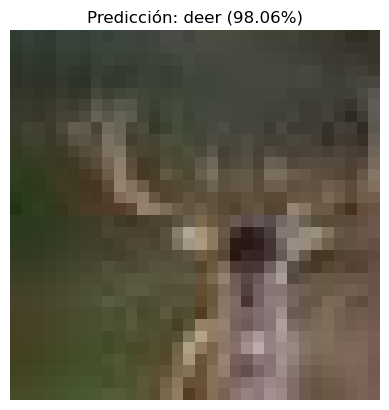


--- Prediciendo: images (39).jpg ---
1/1 [==============================] - 0s 14ms/step


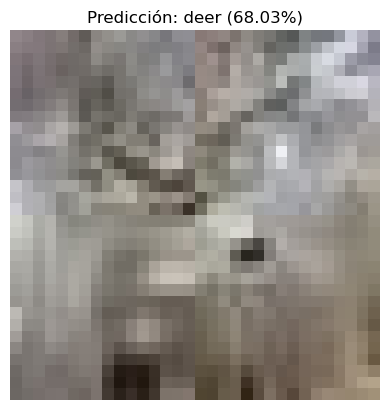


--- Prediciendo: images (4).jpg ---
1/1 [==============================] - 0s 14ms/step


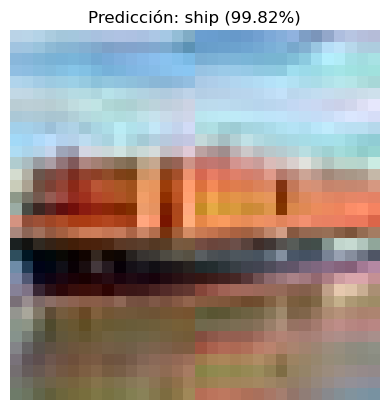


--- Prediciendo: images (40).jpg ---
1/1 [==============================] - 0s 13ms/step


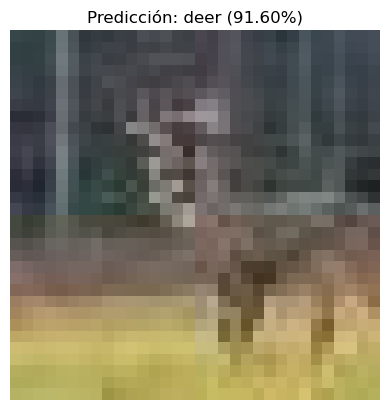


--- Prediciendo: images (41).jpg ---
1/1 [==============================] - 0s 14ms/step


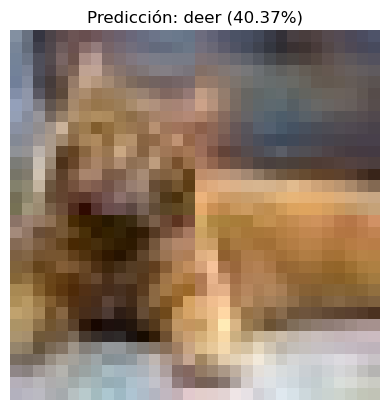


--- Prediciendo: images (42).jpg ---
1/1 [==============================] - 0s 14ms/step


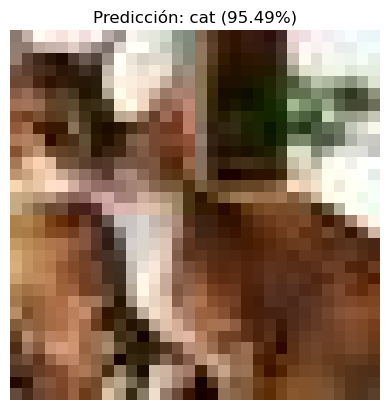


--- Prediciendo: images (43).jpg ---
1/1 [==============================] - 0s 13ms/step


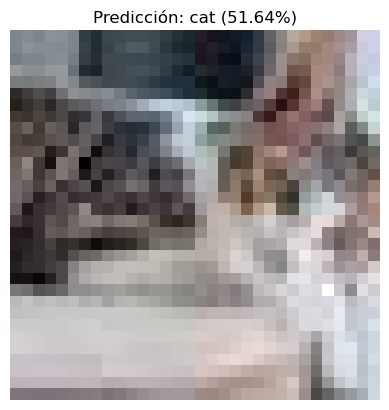


--- Prediciendo: images (44).jpg ---
1/1 [==============================] - 0s 14ms/step


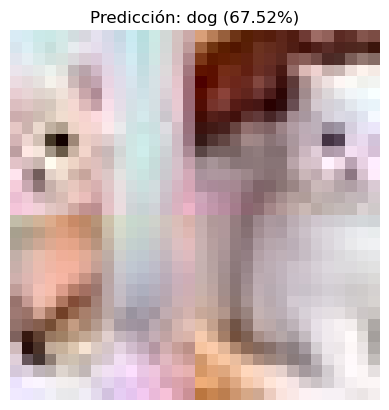


--- Prediciendo: images (45).jpg ---
1/1 [==============================] - 0s 13ms/step


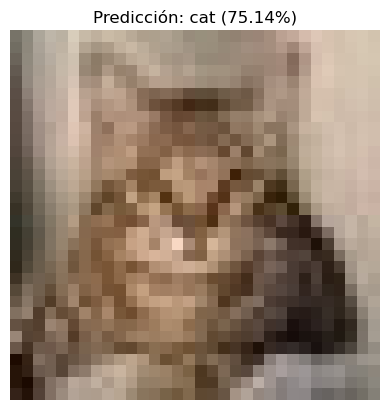


--- Prediciendo: images (46).jpg ---
1/1 [==============================] - 0s 13ms/step


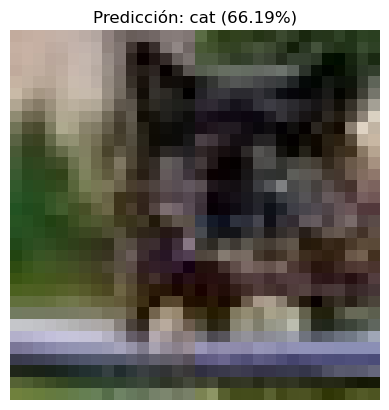


--- Prediciendo: images (47).jpg ---
1/1 [==============================] - 0s 14ms/step


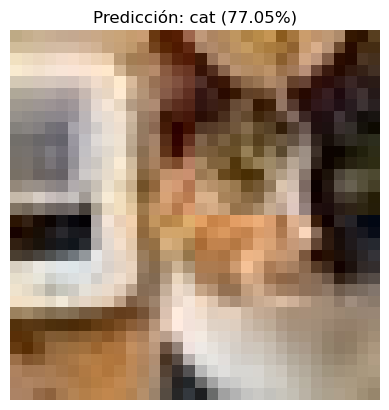


--- Prediciendo: images (48).jpg ---
1/1 [==============================] - 0s 13ms/step


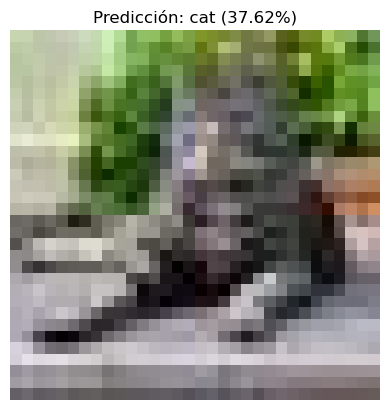


--- Prediciendo: images (49).jpg ---
1/1 [==============================] - 0s 14ms/step


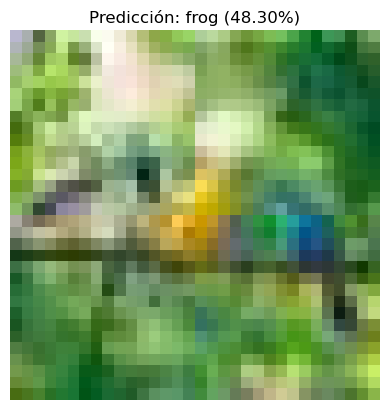


--- Prediciendo: images (5).jpg ---
1/1 [==============================] - 0s 14ms/step


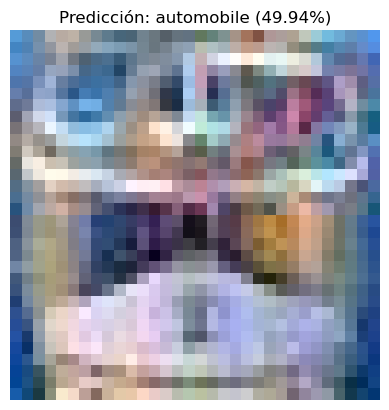


--- Prediciendo: images (50).jpg ---
1/1 [==============================] - 0s 13ms/step


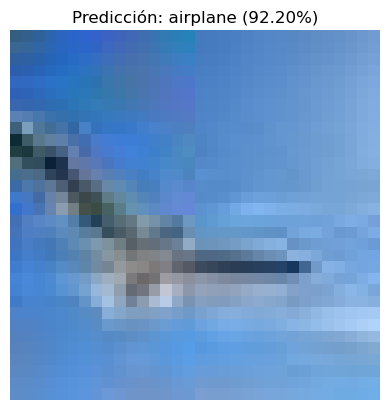


--- Prediciendo: images (51).jpg ---
1/1 [==============================] - 0s 13ms/step


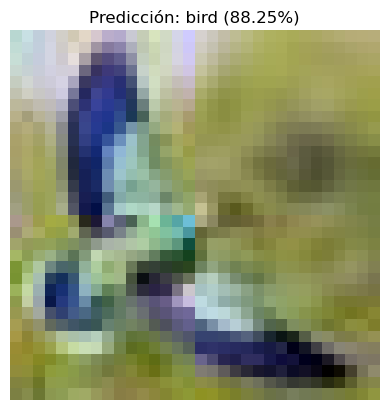


--- Prediciendo: images (52).jpg ---
1/1 [==============================] - 0s 14ms/step


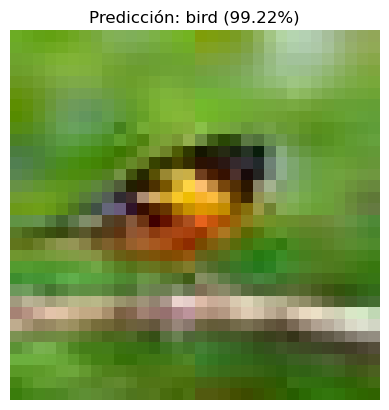


--- Prediciendo: images (53).jpg ---
1/1 [==============================] - 0s 14ms/step


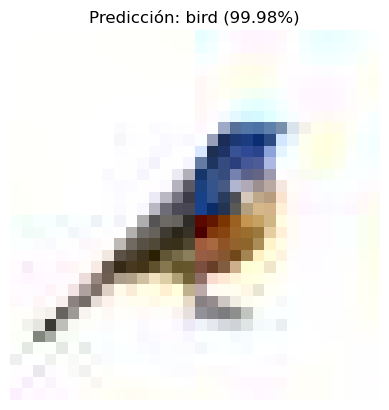


--- Prediciendo: images (54).jpg ---
1/1 [==============================] - 0s 14ms/step


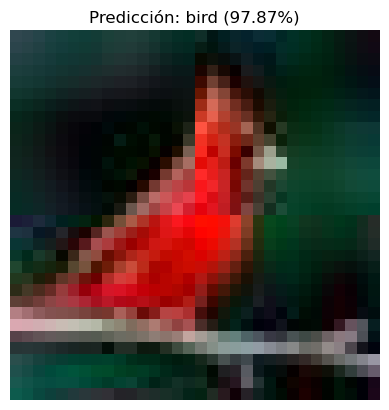


--- Prediciendo: images (55).jpg ---
1/1 [==============================] - 0s 15ms/step


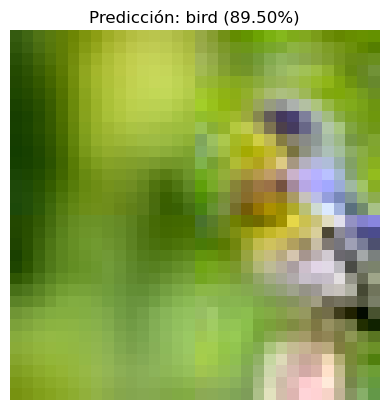


--- Prediciendo: images (56).jpg ---
1/1 [==============================] - 0s 13ms/step


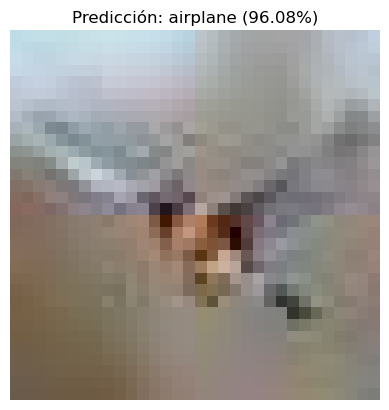


--- Prediciendo: images (57).jpg ---
1/1 [==============================] - 0s 13ms/step


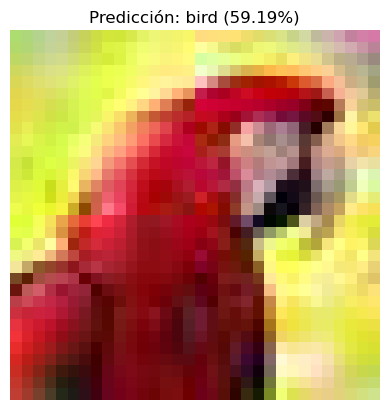


--- Prediciendo: images (58).jpg ---
1/1 [==============================] - 0s 14ms/step


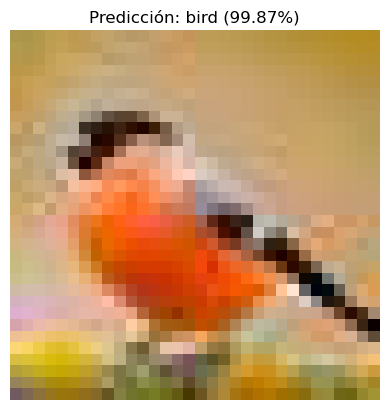


--- Prediciendo: images (59).jpg ---
1/1 [==============================] - 0s 14ms/step


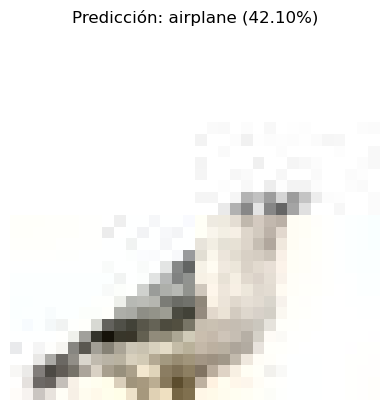


--- Prediciendo: images (6).jpg ---
1/1 [==============================] - 0s 14ms/step


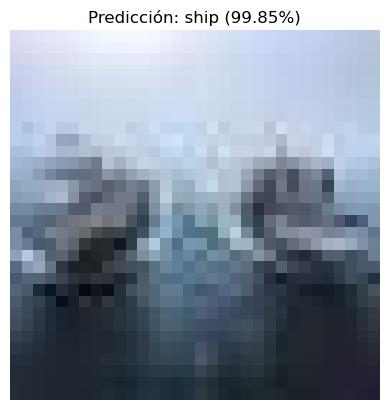


--- Prediciendo: images (60).jpg ---
1/1 [==============================] - 0s 14ms/step


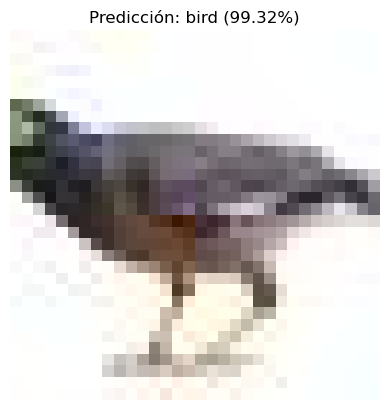


--- Prediciendo: images (61).jpg ---
1/1 [==============================] - 0s 14ms/step


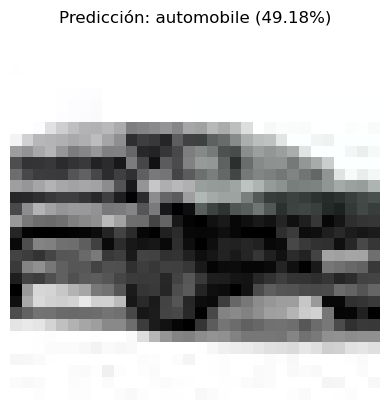


--- Prediciendo: images (62).jpg ---
1/1 [==============================] - 0s 14ms/step


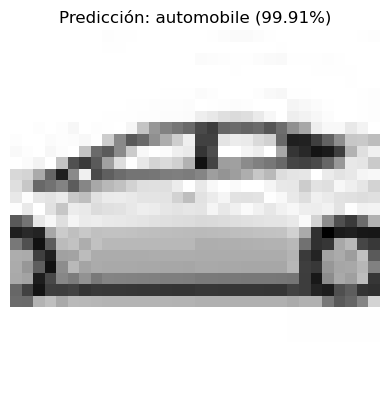


--- Prediciendo: images (63).jpg ---
1/1 [==============================] - 0s 14ms/step


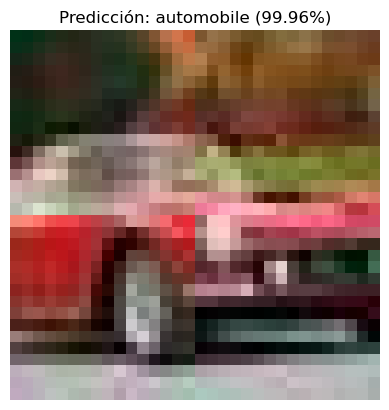


--- Prediciendo: images (64).jpg ---
1/1 [==============================] - 0s 14ms/step


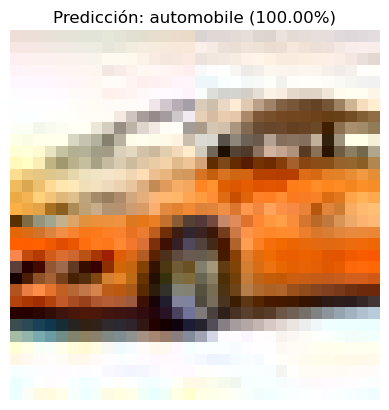


--- Prediciendo: images (65).jpg ---
1/1 [==============================] - 0s 14ms/step


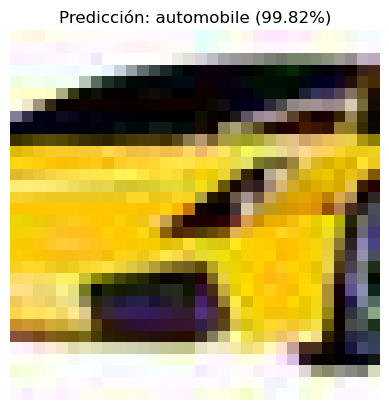


--- Prediciendo: images (66).jpg ---
1/1 [==============================] - 0s 14ms/step


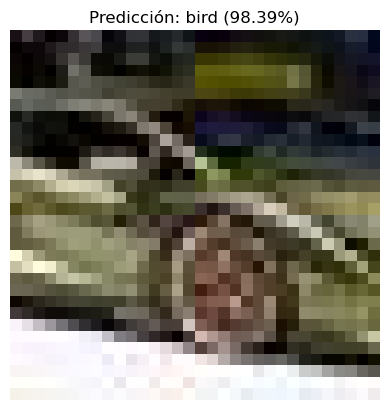


--- Prediciendo: images (67).jpg ---
1/1 [==============================] - 0s 14ms/step


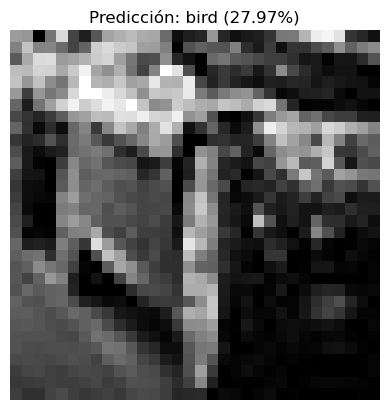


--- Prediciendo: images (68).jpg ---
1/1 [==============================] - 0s 13ms/step


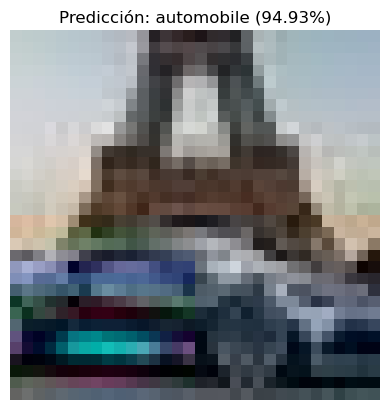


--- Prediciendo: images (69).jpg ---
1/1 [==============================] - 0s 13ms/step


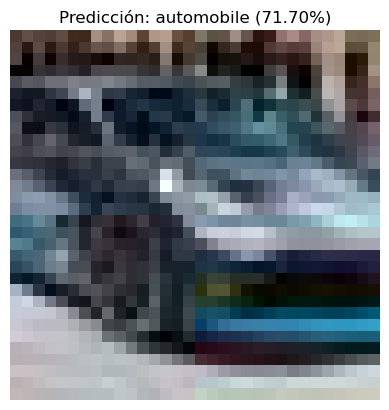


--- Prediciendo: images (7).jpg ---
1/1 [==============================] - 0s 15ms/step


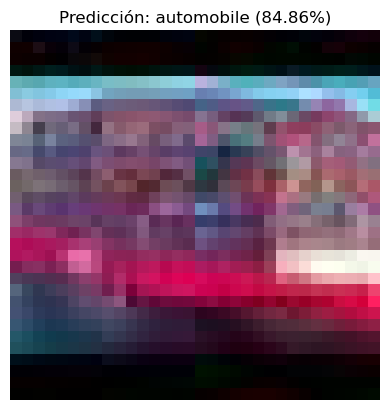


--- Prediciendo: images (70).jpg ---
1/1 [==============================] - 0s 13ms/step


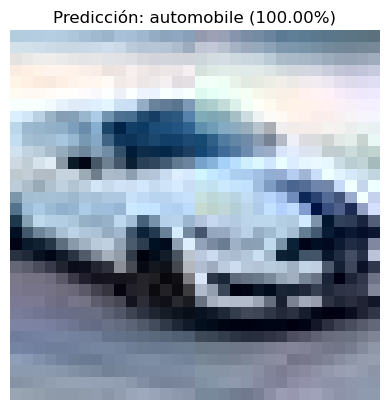


--- Prediciendo: images (71).jpg ---
1/1 [==============================] - 0s 14ms/step


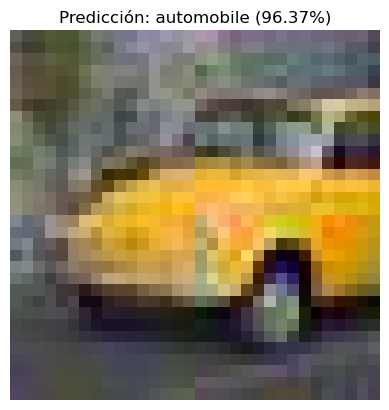


--- Prediciendo: images (72).jpg ---
1/1 [==============================] - 0s 14ms/step


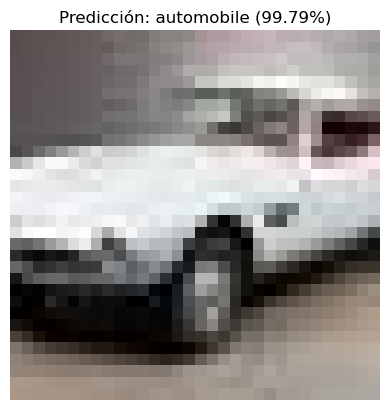


--- Prediciendo: images (73).jpg ---
1/1 [==============================] - 0s 15ms/step


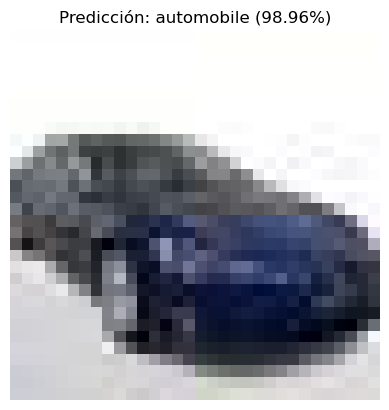


--- Prediciendo: images (74).jpg ---
1/1 [==============================] - 0s 15ms/step


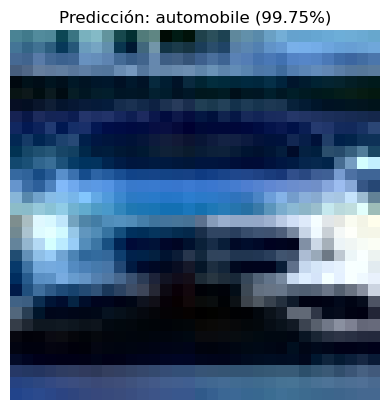


--- Prediciendo: images (75).jpg ---
1/1 [==============================] - 0s 15ms/step


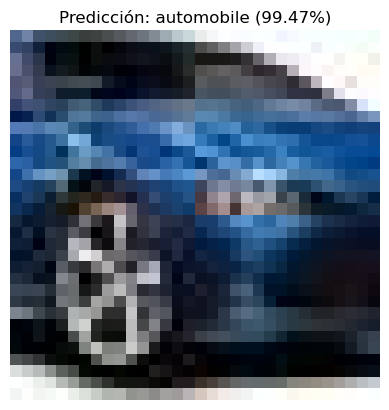


--- Prediciendo: images (76).jpg ---
1/1 [==============================] - 0s 14ms/step


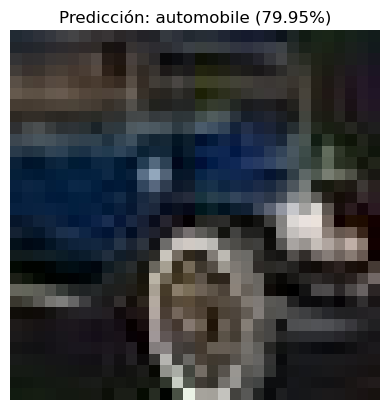


--- Prediciendo: images (77).jpg ---
1/1 [==============================] - 0s 15ms/step


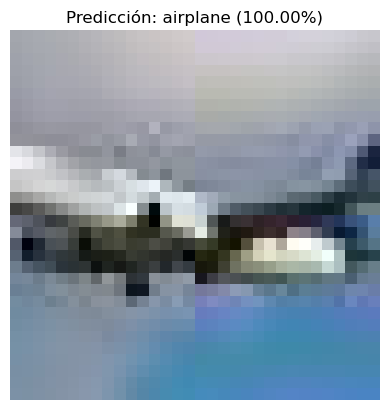


--- Prediciendo: images (78).jpg ---
1/1 [==============================] - 0s 14ms/step


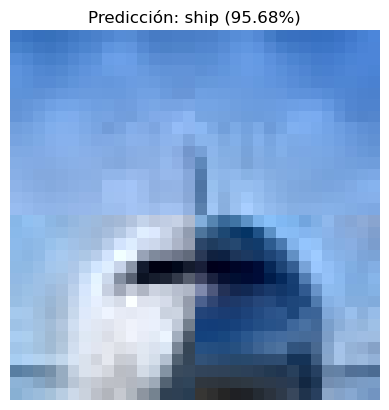


--- Prediciendo: images (79).jpg ---
1/1 [==============================] - 0s 14ms/step


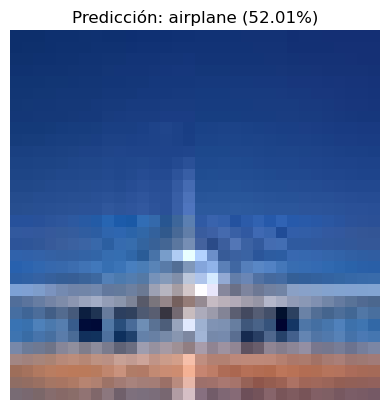


--- Prediciendo: images (8).jpg ---
1/1 [==============================] - 0s 14ms/step


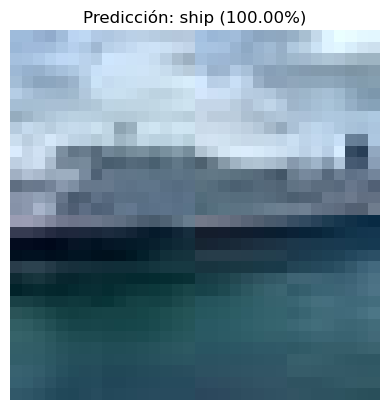


--- Prediciendo: images (80).jpg ---
1/1 [==============================] - 0s 14ms/step


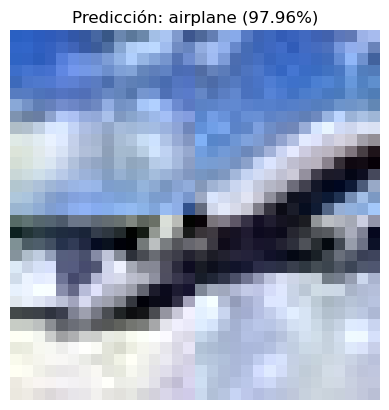


--- Prediciendo: images (81).jpg ---
1/1 [==============================] - 0s 15ms/step


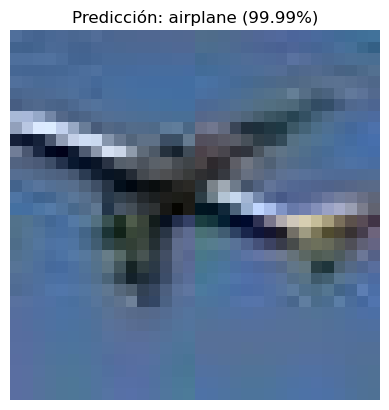


--- Prediciendo: images (82).jpg ---
1/1 [==============================] - 0s 14ms/step


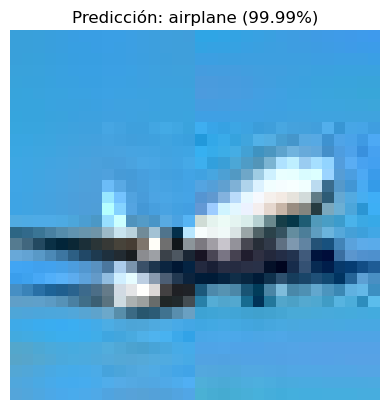


--- Prediciendo: images (83).jpg ---
1/1 [==============================] - 0s 14ms/step


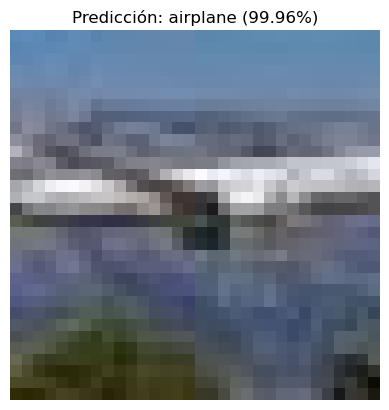


--- Prediciendo: images (84).jpg ---
1/1 [==============================] - 0s 15ms/step


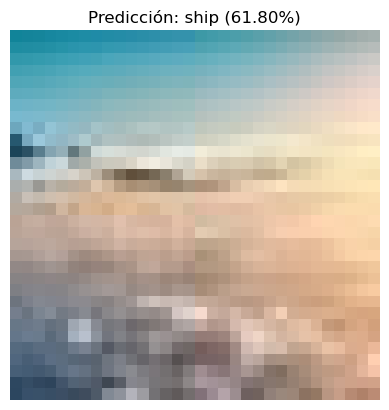


--- Prediciendo: images (85).jpg ---
1/1 [==============================] - 0s 14ms/step


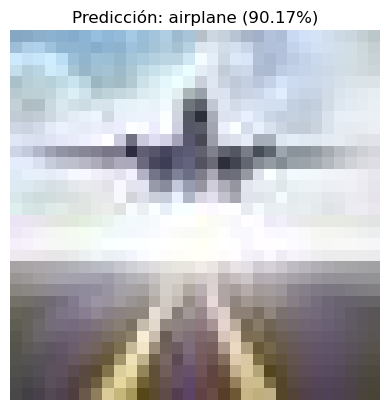


--- Prediciendo: images (86).jpg ---
1/1 [==============================] - 0s 14ms/step


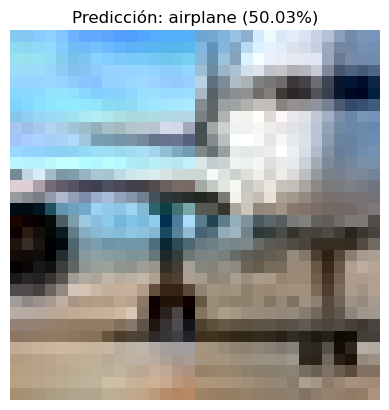


--- Prediciendo: images (87).jpg ---
1/1 [==============================] - 0s 14ms/step


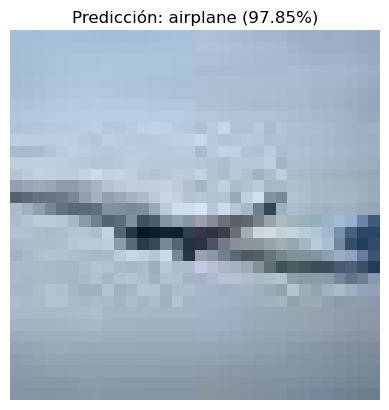


--- Prediciendo: images (88).jpg ---
1/1 [==============================] - 0s 14ms/step


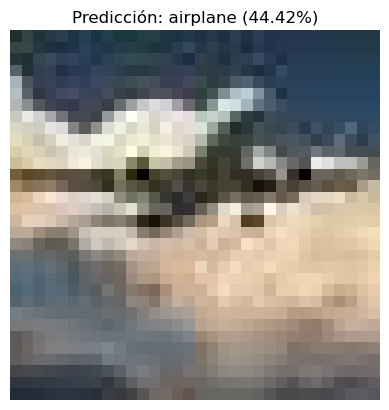


--- Prediciendo: images (89).jpg ---
1/1 [==============================] - 0s 15ms/step


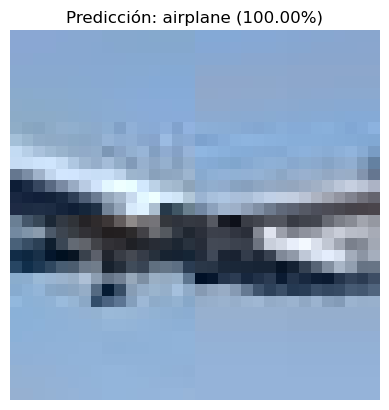


--- Prediciendo: images (9).jpg ---
1/1 [==============================] - 0s 14ms/step


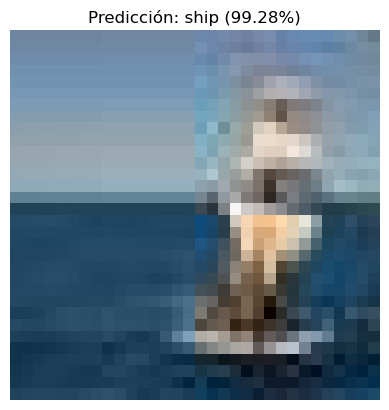


--- Prediciendo: images.jpg ---
1/1 [==============================] - 0s 14ms/step


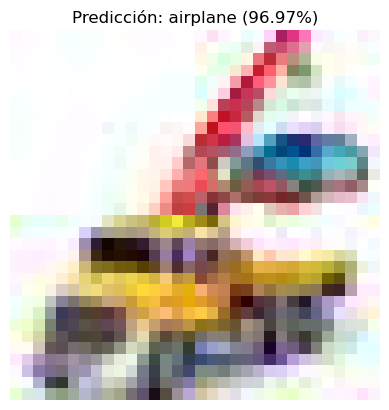


--- Prediciendo: images.png ---
1/1 [==============================] - 0s 13ms/step


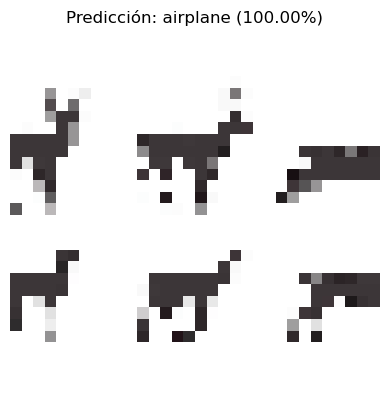

In [16]:
import os

# --- ¡PROBEMOS EL MODELO CON LAS IMÁGENES CORRECTAS! ---

# 1. Define la ruta a tu carpeta con las imágenes YA PROCESADAS
CARPETA_PROCESADAS = r'E:\Procesamiento de Aprendizaje Automatico\Tp\pics_procesadas'

try:
    # 2. Obtener la lista de todos los archivos en la carpeta procesada
    lista_de_archivos = os.listdir(CARPETA_PROCESADAS)
    
    extensiones_validas = ('.png', '.jpg', '.jpeg', '.bmp')
    imagenes_a_predecir = [f for f in lista_de_archivos if f.lower().endswith(extensiones_validas)]

    if not imagenes_a_predecir:
        print(f"No se encontraron imágenes en la carpeta: {CARPETA_PROCESADAS}")
        print("Asegúrate de haber ejecutado primero el script 'preprocesar_imagenes.py'.")
    else:
        print(f"Iniciando predicciones para las {len(imagenes_a_predecir)} imágenes procesadas...")
        
        # 3. Recorrer cada imagen y llamar a la función de predicción
        for nombre_archivo in imagenes_a_predecir:
            ruta_completa = os.path.join(CARPETA_PROCESADAS, nombre_archivo)
            
            print(f"\n--- Prediciendo: {nombre_archivo} ---")
            
            # Llamar a la función que definiste en la celda anterior
            predecir_imagen_externa(ruta_completa, best_model)

except FileNotFoundError:
    print(f"Error: No se encontró la carpeta en la ruta '{CARPETA_PROCESADAS}'.")
    print("Por favor, asegúrate de que la ruta es correcta y que has ejecutado 'preprocesar_imagenes.py'.")
except NameError:
    print("Error: La variable 'best_model' o la función 'predecir_imagen_externa' no están definidas.")
    print("Por favor, ejecuta primero las celdas anteriores que las definen.")
